# Data Preprocessing

### 1. Imports and Configuration

In [166]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set seed for reproducibility
Seed = 42

### 2. Load Images and labels

In [167]:
dataset_dir = '/kaggle/input/satellite-data/Satellite Data'

imgs_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')

# Get the images and labels paths
images_paths = sorted([os.path.join(imgs_dir, img) for img in os.listdir(imgs_dir)])
labels_paths = sorted([os.path.join(labels_dir, lbl) for lbl in os.listdir(labels_dir)])

# Load the images and labels
images = np.array([tiff.imread(img).astype(np.float32) for img in images_paths])
labels = np.array([np.array(Image.open(lbl).convert("L")) for lbl in labels_paths])

# Expand label channels to (H, W, 1)
if labels.ndim == 3:
    labels = np.expand_dims(labels, axis=-1)

# Show the shape of images and labels
print(f"Image shape: {images[0].shape}\nLabel shape: {labels[0].shape}")

Image shape: (128, 128, 12)
Label shape: (128, 128, 1)


### 3. Split the Data into Train/Validation/Test Splits

In [168]:
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=Seed)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, shuffle=False, random_state=Seed)

print("Train:", len(train_imgs))
print("Validation:", len(val_imgs))
print("Test:", len(test_imgs))

Train: 244
Validation: 31
Test: 31


### 4. Data Augmentation ONLY! and Pipeline Handling
The dataset is already normalized. Note: We can not use **ImageDataGenerator** here as it deals only with data whose shape contains only 1, 3, or 4 channels. But our satellite data contains 12 channels

In [169]:
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))
    return image, label
    
# Create tf.data.Dataset from numpy arrays
train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_imgs, val_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels))

train_data = (
    train_data
    .shuffle(buffer_size=1000, seed=Seed)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

### 5. Visualize Some Augmented Training Samples (RGB Only)
The Plot contains the RGB channels only.

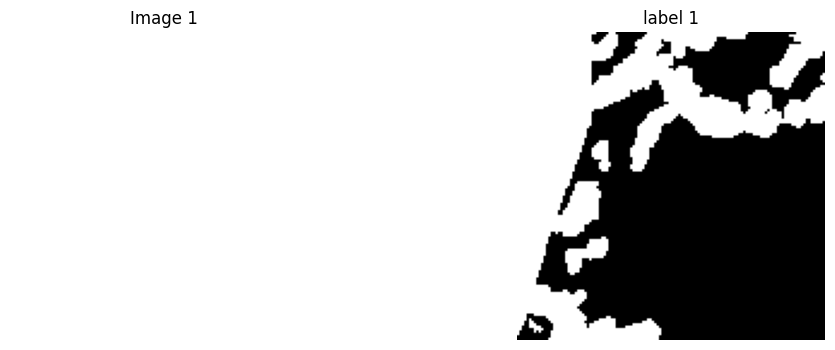

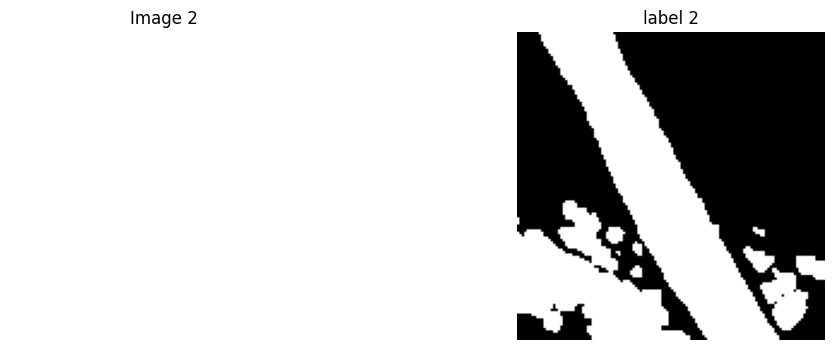

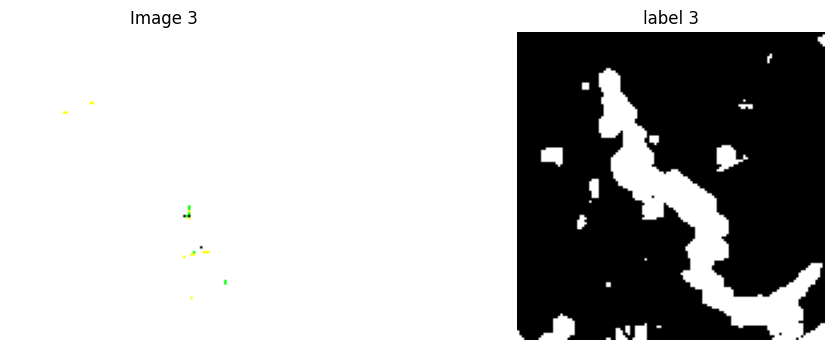

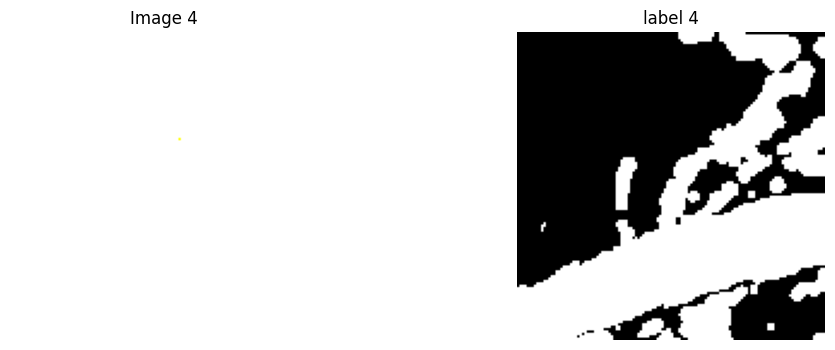

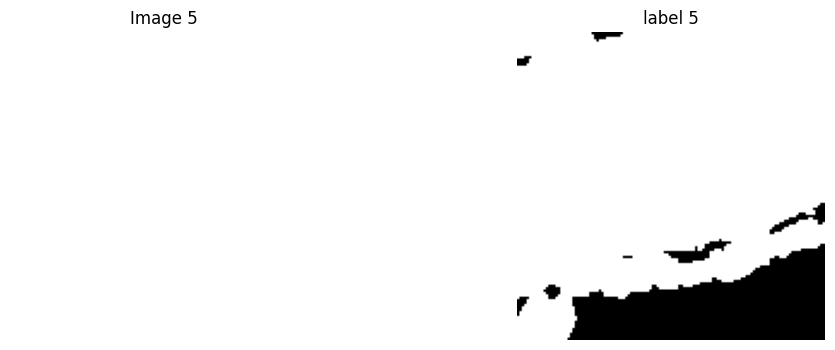

In [170]:
for img_batch, label_batch in train_data.take(1):
    # Plot 5 samples
    for i in range(5):
        img = img_batch[i].numpy()
        label = label_batch[i].numpy().squeeze()

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img[..., [3, 2, 1]])  # Use bands 3, 2, 1 for Red, Green, Blue
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title(f"label {i+1}")
        plt.axis("off")

        plt.show()

### 6. Visualize Some Augmented Training Samples with Every Channel

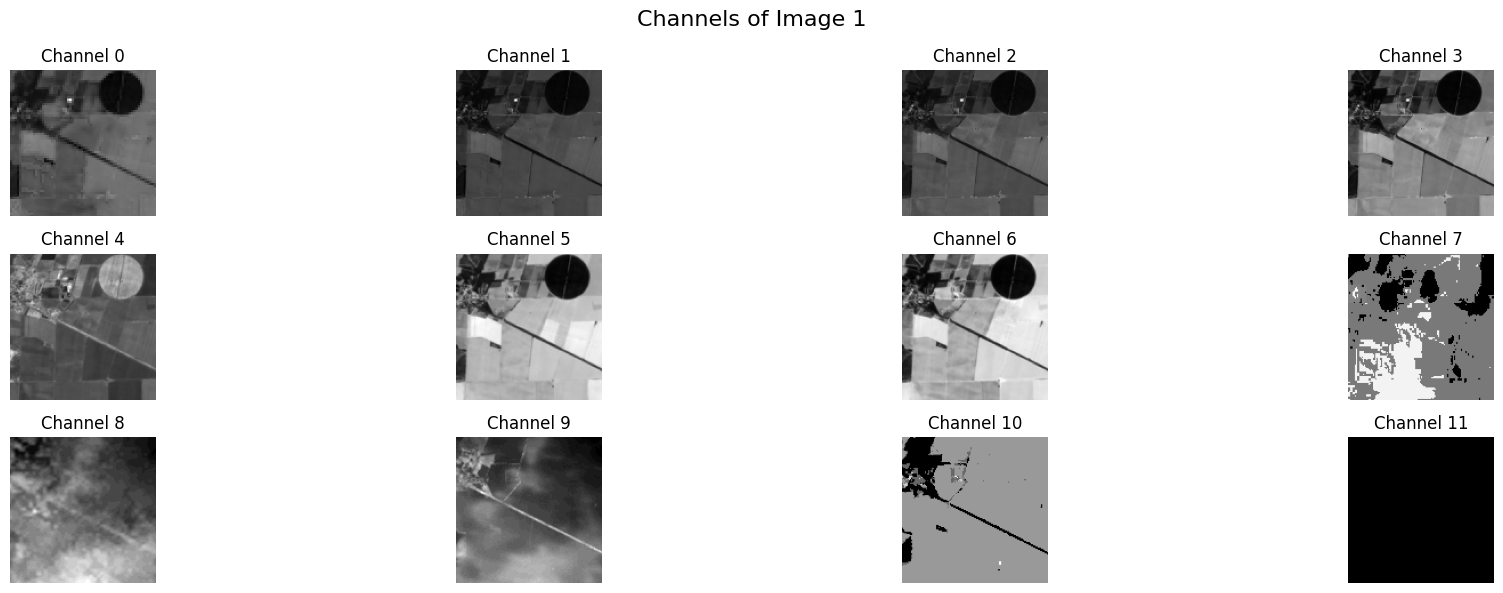

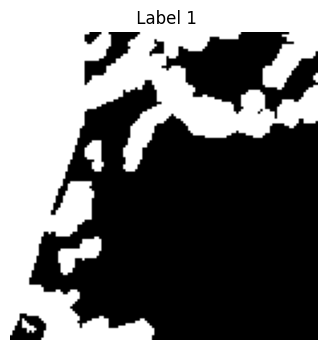

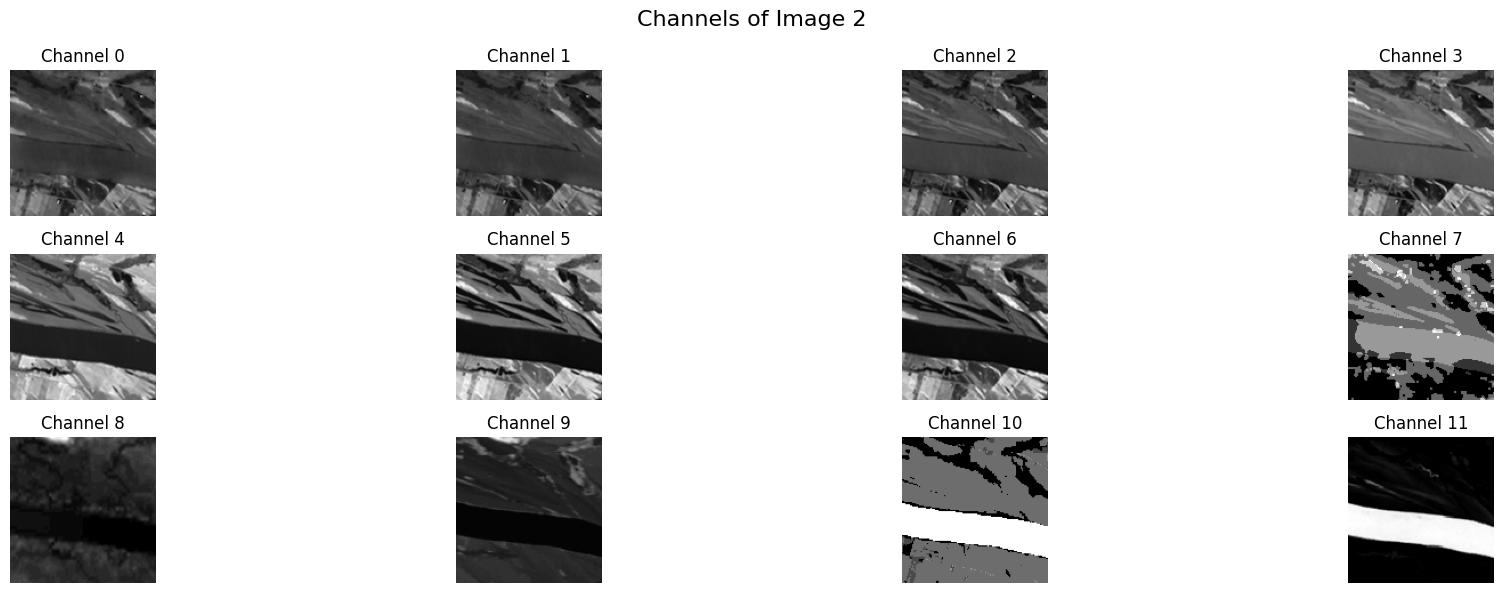

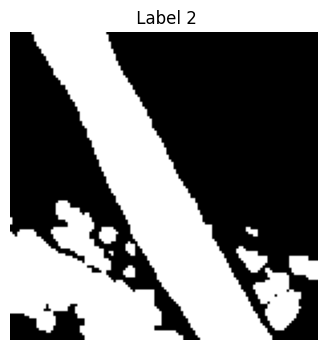

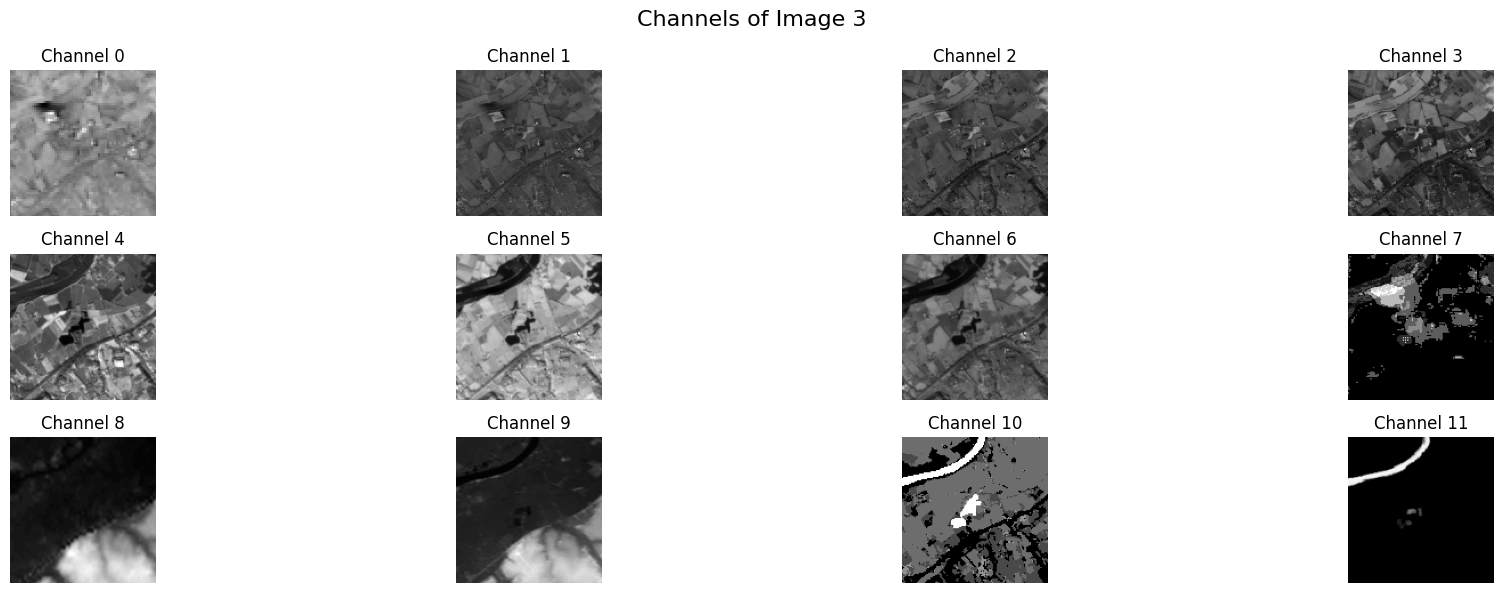

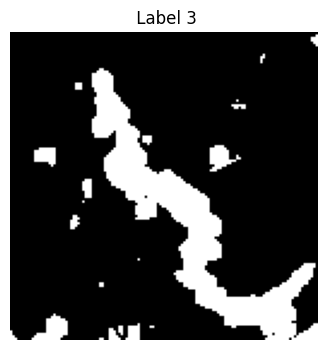

In [171]:
for img_batch, mask_batch in train_data.take(1):
    # Plot 3 samples
    for k in range(3):
        img = img_batch[k].numpy()
        label = label_batch[k].numpy().squeeze()

        plt.figure(figsize=(20, 6))
        for i in range(12):
            plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns = 12 subplots
            plt.imshow(img[..., i], cmap='gray')
            plt.title(f'Channel {i}')
            plt.axis('off')
        plt.suptitle(f"Channels of Image {k+1}", fontsize=16)
        plt.tight_layout()
        plt.show()

        # Optional: also show the mask
        plt.figure(figsize=(4, 4))
        plt.imshow(label, cmap='gray')
        plt.title(f" Label {k+1}")
        plt.axis('off')
        plt.show()

# Model Creation and Evaluation

### 1. Build the Model Architecture

In [172]:
def build_unet(input_shape=(128, 128, 12)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    def conv_block(x, filters):
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        return conv_block(x, filters)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer: 1 channel for binary mask, sigmoid for binary segmentation
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(d4)

    return tf.keras.Model(inputs, outputs)

# Build the model
model = build_unet(input_shape=(128, 128, 12))
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_399 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_25[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_400 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_399[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_94    │ (None, 64, 64,    │          0 │ conv2d_400[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_401 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_94… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_402 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_401[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_95    │ (None, 32, 32,    │          0 │ conv2d_402[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_403 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_95… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_404 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_403[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_96    │ (None, 16, 16,    │          0 │ conv2d_404[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_405 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_96… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_406 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_405[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_97    │ (None, 8, 8, 512) │          0 │ conv2d_406[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_407 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_97… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_408 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_407[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_79 │ (None, 16, 16,    │  2,097,664 │ conv2d_408[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_79      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Compile the Model

In [173]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])

### 3. Train the Model

In [174]:
import math
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30
# steps_per_epoch = math.ceil(len(train_imgs) / BATCH_SIZE)
# validation_steps = math.ceil(len(val_imgs) / BATCH_SIZE)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1)

history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stop])

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 258ms/step - accuracy: 0.6018 - loss: 53.9204 - mean_io_u_19: 0.3574 - val_accuracy: 0.8271 - val_loss: 1.1745 - val_mean_io_u_19: 0.4328
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7337 - loss: 1.2891 - mean_io_u_19: 0.3997 - val_accuracy: 0.6613 - val_loss: 1.5543 - val_mean_io_u_19: 0.4059
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6631 - loss: 1.4987 - mean_io_u_19: 0.3749 - val_accuracy: 0.8246 - val_loss: 0.4134 - val_mean_io_u_19: 0.4127
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7230 - loss: 1.2178 - mean_io_u_19: 0.3827 - val_accuracy: 0.2037 - val_loss: 5.4498 - val_mean_io_u_19: 0.4337
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.6368 - loss: 2.4633 - mean_io_u_19: 0.3920 - val_accuracy: 0.8296 - val_loss: 0.6863 - val_mean_io_u_19: 0.4102
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6260 - loss: 1.6072 - mean_io_u_19: 0.3655 - va

# Model Evaluation

### 1. Test the Model

In [194]:
eval = model.evaluate(test_data)
print(f'Test Accuracy: {eval[1]*100:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9128 - loss: 0.2653 - mean_io_u_19: 0.3792
Test Accuracy: 90.35


### 2. Visualize the Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


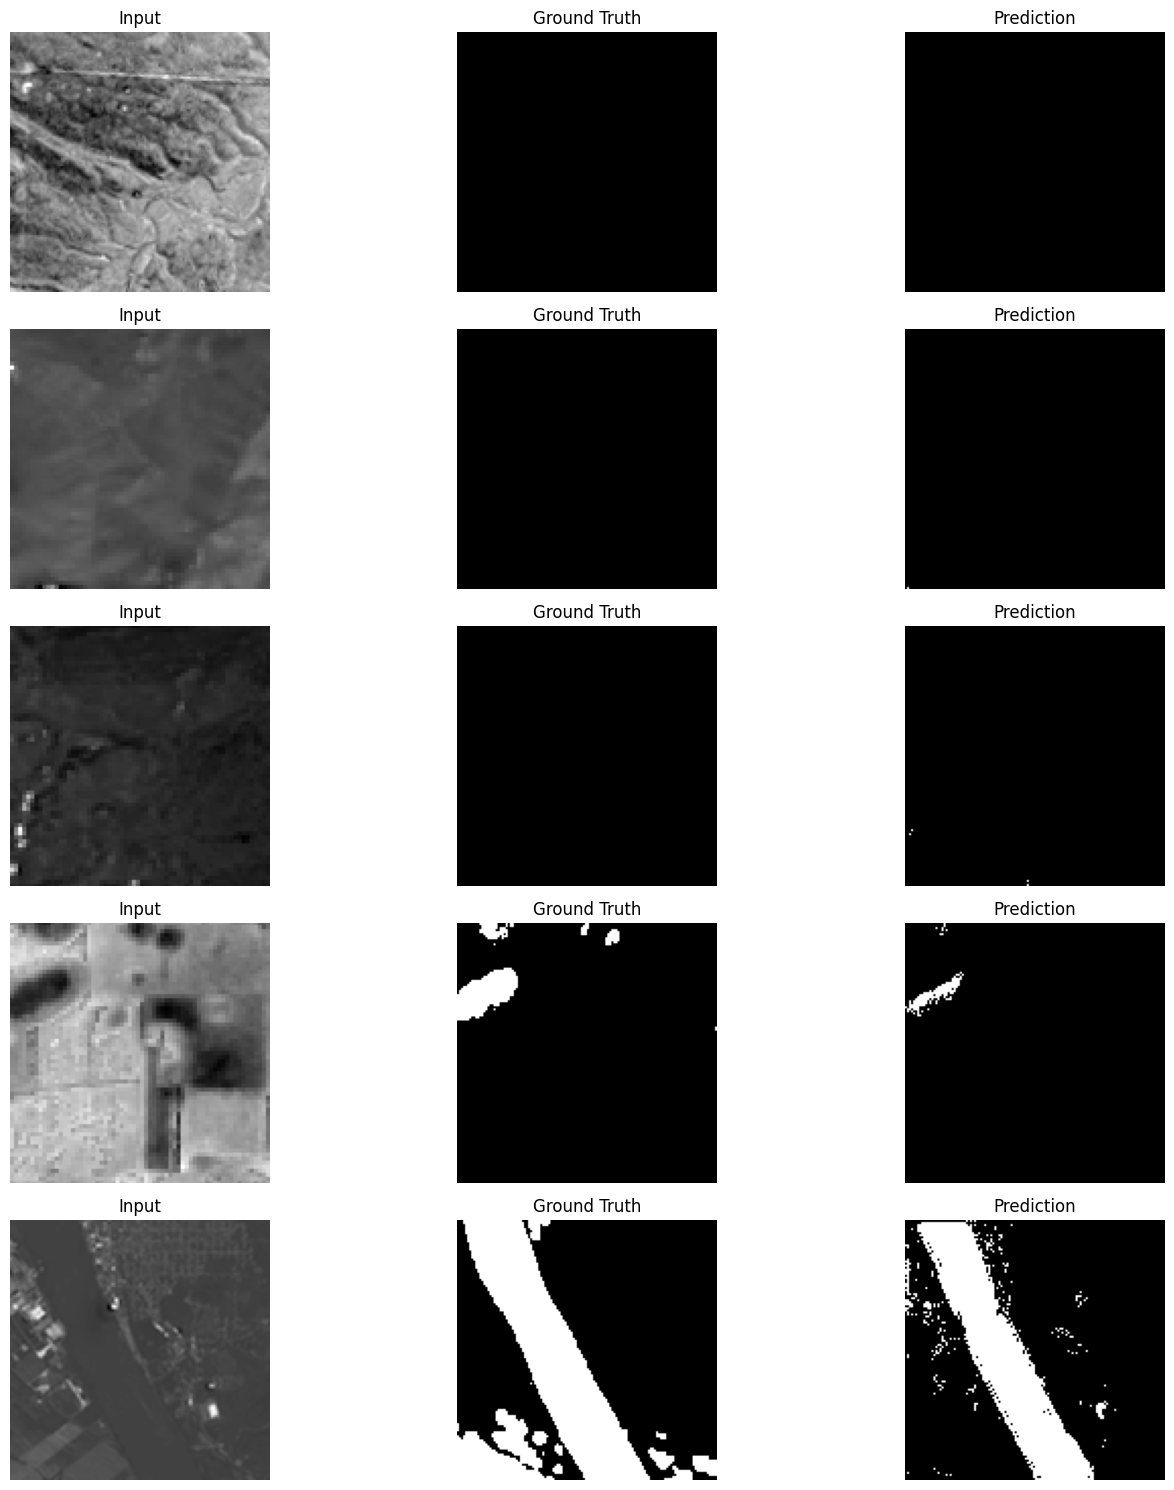

In [195]:
# Take a batch from the test dataset
for images, labels in test_data.take(1):
    predictions = model.predict(images)
    pred_labels = predictions > 0.5

    num_samples = 5  # Adjust how many samples you want to show
    plt.figure(figsize=(15, num_samples * 3))

    for i in range(num_samples):
        # Input image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i][:, :, 0], cmap='gray')
        plt.title("Input")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(tf.squeeze(labels[i]), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(tf.squeeze(pred_labels[i]), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### 3. Save the Model

In [193]:
model.save('satellite_water_segmentation.h5')

### 4. Download the Model

In [196]:
from IPython.display import FileLink

FileLink('satellite_water_segmentation.h5')

/kaggle/working/satellite_water_segmentation.h5